In [ ]:
import tensorflow as tf
tf.__version__
import keras
keras.__version__

'2.8.0'

# 1. Extract and split image dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

In [ ]:
files = zf.ZipFile("dataset_folder.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"dataset_folder"))

['paper', 'glass', 'plastic', 'metal']

In [ ]:
## Helper functions ##

## Splits indices for a folder into train, validation, and test indices with random sampling
    ## args: folder path
    ## returns: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))
    
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.7*n))
    
    remain = list(set(full_set)-set(train))
    
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## Gets file names for a particular type of trash, given indices
    ## args: waste category and indices
    ## returns: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## Moves group of source files to another folder
    ## args: list of source files and destination folder
    ## no returns
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## Paths will be train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['glass','metal','paper','plastic']

## Create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

In [ ]:
## Move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset_folder',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## Move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## Move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## Move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type

    ## Use data/test here because the images can be mixed up
    move_files(test_source_files, test_dest)

# 2. Construct and build model

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import Dropout
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import  classification_report

In [ ]:
base_model = MobileNetV2(weights='imagenet',include_top=False,
                     input_shape=(224, 224, 3)) # Imports  mobilenet model and discards last 1000 neuron layer.

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) # Add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x) # Dense layer 2
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) # Dense layer 3
x = Dropout(0.2)(x)
preds = Dense(4,activation='softmax')(x) # Final layer with softmax activation
model = Model(inputs=base_model.input,outputs=preds)

In [ ]:
len(model.layers)

162

In [ ]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Add  data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2) # Your Code Here

# NOTE: the validation data should not be augmented
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from imutils import paths
train_dir = 'data/train'
validation_dir = 'data/valid/'
test_dir = 'data/test/'
totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))
print("Total Training: ", totalTrain)
print("Total Validation: ",totalVal)
print("Total test: ", totalTest)

Total Training:  1389
Total Validation:  297
Total test:  301


In [5]:
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                   target_size=TARGET_SIZE)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                   batch_size=BATCH_SIZE,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   target_size=TARGET_SIZE)

# Initialize the testing generator
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    class_mode="categorical",
    color_mode='rgb',
    target_size=TARGET_SIZE,  
    shuffle=False, 
    batch_size=BATCH_SIZE)

Found 1389 images belonging to 4 classes.
Found 297 images belonging to 4 classes.
Found 301 images belonging to 4 classes.


In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train head of the network for few epochs (all other layers are frozen)
# This allows the new FC layers to start to be
# initialized with actual "learned" values versus purely random values

print("[INFO] trainning head...")
H = model.fit( 
    train_generator,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=50)

[INFO] trainning head...
Epoch 1/50
86/86 [==============================] - 27s 251ms/step - loss: 1.5683 - accuracy: 0.2709 - val_loss: 1.3443 - val_accuracy: 0.3646
Epoch 2/50
86/86 [==============================] - 21s 240ms/step - loss: 1.4340 - accuracy: 0.3307 - val_loss: 1.2564 - val_accuracy: 0.4549
Epoch 3/50
86/86 [==============================] - 21s 240ms/step - loss: 1.3975 - accuracy: 0.3387 - val_loss: 1.1783 - val_accuracy: 0.5833
Epoch 4/50
86/86 [==============================] - 21s 238ms/step - loss: 1.2855 - accuracy: 0.4173 - val_loss: 1.1080 - val_accuracy: 0.6389
Epoch 5/50
86/86 [==============================] - 22s 250ms/step - loss: 1.2312 - accuracy: 0.4355 - val_loss: 1.0281 - val_accuracy: 0.6979
Epoch 6/50
86/86 [==============================] - 21s 239ms/step - loss: 1.1745 - accuracy: 0.4924 - val_loss: 0.9502 - val_accuracy: 0.7083
Epoch 7/50
86/86 [==============================] - 21s 239ms/step - loss: 1.1039 - accuracy: 0.5295 - val_loss: 0.88

# 3. Evaluation of model

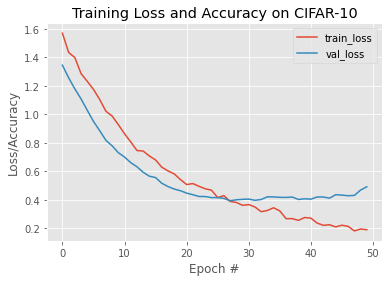

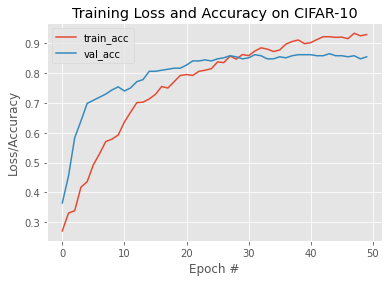

In [ ]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Reset the test generator and evaluate network after fine-tuning network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict_generator(test_generator, 
     steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs, 
     target_names=test_generator.class_indices.keys()))

[INFO] evaluating after fine-tuning network head...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


              precision    recall  f1-score   support

       glass       0.98      0.74      0.84        76
       metal       0.81      0.90      0.85        62
       paper       0.95      0.99      0.97        90
     plastic       0.86      0.96      0.91        73

    accuracy                           0.90       301
   macro avg       0.90      0.90      0.89       301
weighted avg       0.91      0.90      0.90       301



In [ ]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save('model.h5')

[INFO] serializing network...


In [2]:
# import the necessary packages
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
%matplotlib inline

In [7]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('model.h5')

[INFO] loading model...


In [3]:
from keras.applications.mobilenet import decode_predictions, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import imutils
import cv2
%matplotlib inline

2022-08-26 22:04:11.553935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-26 22:04:11.554091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


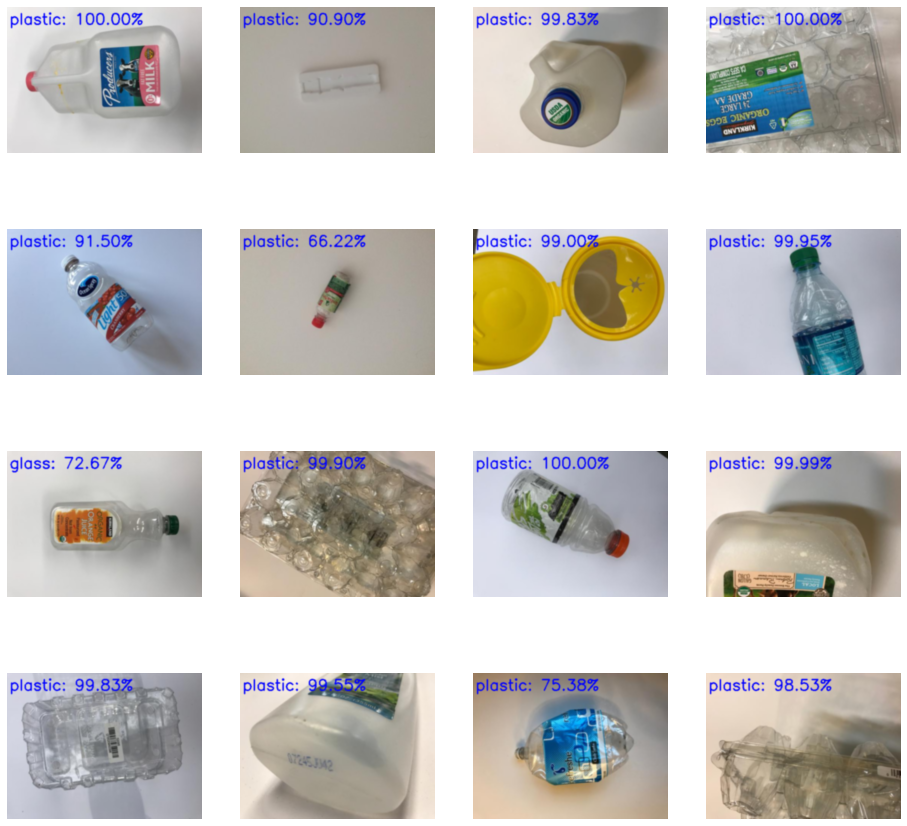

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8

# load the input image and then clone it so we can draw on it later
waste_types = ['glass','metal','paper','plastic']
test_d = 'data/test/' + waste_types[3] + '/'
# test_d = 'mytest/'
test_files = os.listdir(test_d)[0:16]
for i, fn in enumerate(test_files):
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, facecolor='red')
    sp.axis('Off') # Don't show axes (or gridlines)
    # predicting images
    path = test_d + fn
    image = cv2.imread(path)

    img = load_img(path, target_size=TARGET_SIZE)

    output = image.copy()
    output = imutils.resize(output, width=400)

    img = img_to_array(img)
    
    # our model was trained on RGB ordered images but OpenCV represents
    # images in BGR order, so swap the channels, and then resize to
    # 224x224 (the input dimensions for VGG16)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    # print(image.shape)
    
    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32") / 255.
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # pass the image through the network to obtain our predictions
    # preds = model.predict(np.expand_dims(image / 255., axis=0))[0]
    preds = model.predict(img)[0]
    i = np.argmax(preds)
    label = waste_types[i]
    # print(label)
    
    # draw prediction on the output image
    text = "{}: {:.2f}%".format(label, preds[i] * 100)
    cv2.putText(output, text, (5, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.05,
        (255, 0, 0), 2)
    
    # show output 
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
plt.show()